In [ ]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

In [2]:
df_accel = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_accelerometer.csv")
df_gyro = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_gyroscope.csv")

In [3]:
df_accel = normalize_columns(df_accel, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

df_gyro = normalize_columns(df_gyro, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

In [4]:
df_accel = convert_timestamp(df_accel)
df_gyro = convert_timestamp(df_gyro)

In [5]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [6]:
df_gyro = df_all_sensors.select(
            pl.col('Subject-id'), 
            pl.col('Timestamp'), 
            pl.col('Activity Label'),
            pl.col('X'), 
            pl.col('Y'), 
            pl.col('Z')
        )
df_accel = df_all_sensors.select(
            pl.col('Subject-id'), 
            pl.col('Timestamp'), 
            pl.col('Activity Label'),
            pl.col('X_right').alias('X'), 
            pl.col('Y_right').alias('Y'), 
            pl.col('Z_right').alias('Z')
        )


In [7]:
df_gyro_group = convert_frequences(df_gyro, hz = 20)
df_accel_group = convert_frequences(df_accel, hz = 20)

🔄 Convirtiendo a 20Hz (ventanas de 50ms)
📊 Procesando usuario 1/9: i
  🎯 Actividad: sit (189 muestras)
    ✅ 189 → 21 muestras
  🎯 Actividad: null (2632 muestras)
    ✅ 2632 → 300 muestras
  🎯 Actividad: stand (261 muestras)
    ✅ 261 → 42 muestras
  🎯 Actividad: stairsup (4416 muestras)
    ✅ 4416 → 441 muestras
  🎯 Actividad: stairsdown (2478 muestras)
    ✅ 2478 → 277 muestras
📊 Procesando usuario 2/9: f
  🎯 Actividad: null (70154 muestras)
    ✅ 70154 → 6980 muestras
  🎯 Actividad: sit (61307 muestras)
    ✅ 61307 → 6051 muestras
  🎯 Actividad: bike (76806 muestras)
    ✅ 76806 → 7619 muestras
  🎯 Actividad: stairsdown (55875 muestras)
    ✅ 55875 → 5540 muestras
  🎯 Actividad: stairsup (59580 muestras)
    ✅ 59580 → 5906 muestras
  🎯 Actividad: stand (63644 muestras)
    ✅ 63644 → 6286 muestras
  🎯 Actividad: walk (65023 muestras)
    ✅ 65023 → 6462 muestras
📊 Procesando usuario 3/9: g
  🎯 Actividad: stairsdown (2251 muestras)
    ✅ 2251 → 226 muestras
  🎯 Actividad: bike (13969 m

In [ ]:
features_gyro = create_feature_windows(df_gyro_group, window_seconds=5, overlap_percent=50)
features_accel = create_feature_windows(df_accel_group, window_seconds=5, overlap_percent=50)

In [18]:
features_combined = pd.merge(
    features_gyro,
    features_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [14]:
from tensorflow import keras
model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn_lstm_har_model_92.h5')

In [15]:
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\label_encoder_92%.joblib')

In [24]:
activities_dict = {
    'Walk': ['walk', 'stairsup', 'stairsdown'],
    'Stand': ['stand'],
    'Sit': ['sit'],
    'Others': ['null', 'bike']
}

for activity in activities_dict.keys():
    for old_activity in activities_dict[activity]:
        features_combined.loc[features_combined['Activity Label'] == old_activity, 'Activity Label'] = activity

In [23]:
np.unique(y)

array(['bike', 'null', 'sit', 'stairsdown', 'stairsup', 'stand', 'walk'],
      dtype=object)

In [30]:
Xs, ys, label_encoder = get_features_split(features_combined)

Características detectadas: 136
Muestras totales: 4971
Número de clases: 4
Clases: ['Others' 'Sit' 'Stand' 'Walk']


In [ ]:
model = 

[ 3 10 10 ...  3 10 10]


In [26]:
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X, y, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Pérdida en test: 9.9061
Precisión en test: 0.1157

REPORTE DE CLASIFICACIÓN


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

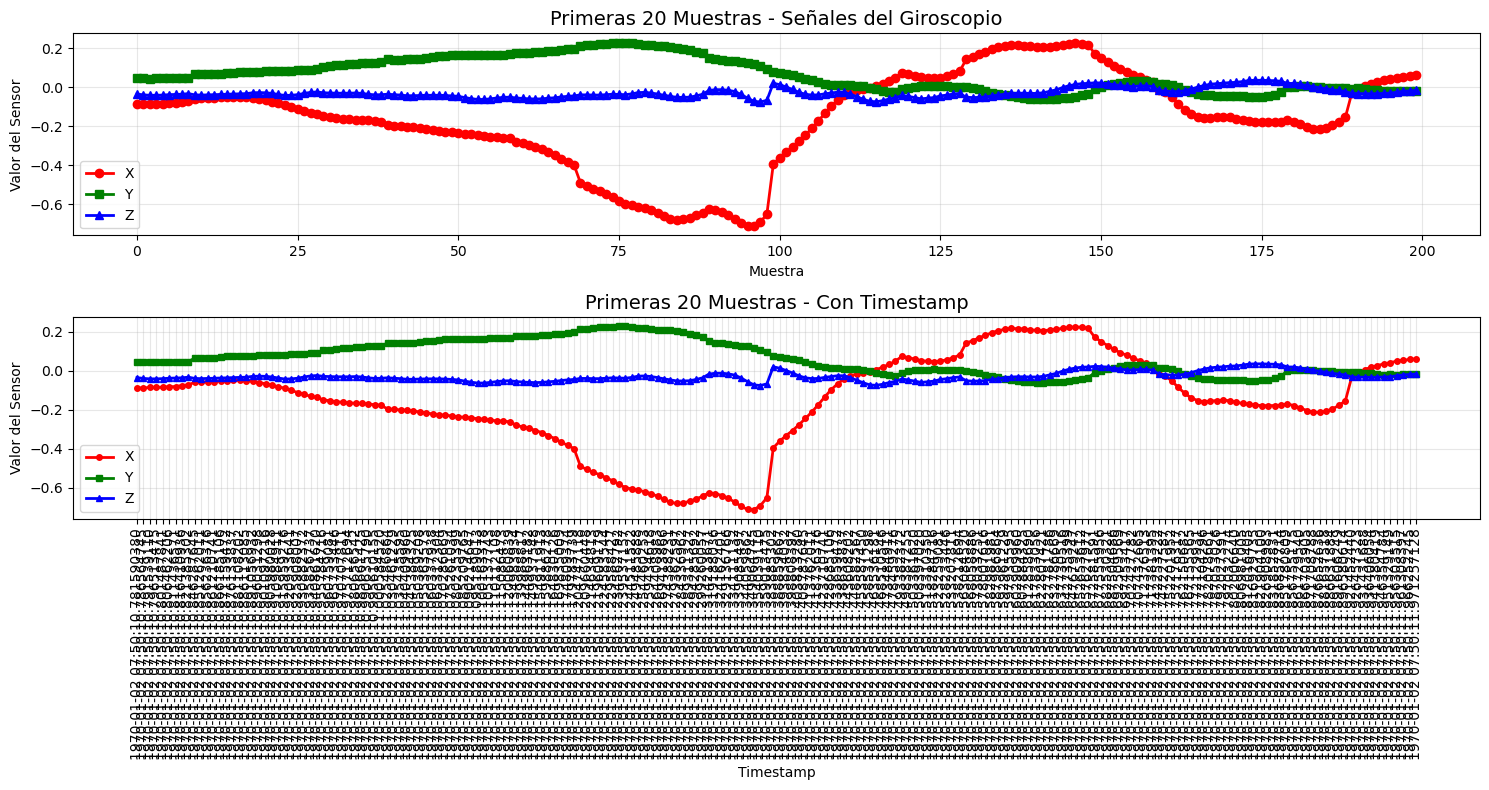

In [ ]:
# Visualización de las primeras 20 muestras
plt.figure(figsize=(15, 8))

df = df_gyro
# Convertir a pandas para facilitar la visualización
df_sample = df.head(200).to_pandas()
df_sample['Tiempo Hora'] = df_sample['Timestamp'].dt.strftime('%H:%M:%S.%2f')

plt.subplot(2, 1, 1)
plt.plot(range(200), df_sample['X'], 'r-o', label='X', linewidth=2, markersize=6)
plt.plot(range(200), df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=6)
plt.plot(range(200), df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=6)
plt.title('Primeras 20 Muestras - Señales del Giroscopio', fontsize=14)
plt.xlabel('Muestra')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualización con timestamp real
plt.subplot(2, 1, 2)
plt.plot(df_sample['Tiempo Hora'], df_sample['X'], 'r-o', label='X', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=4)
plt.title('Primeras 20 Muestras - Con Timestamp', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

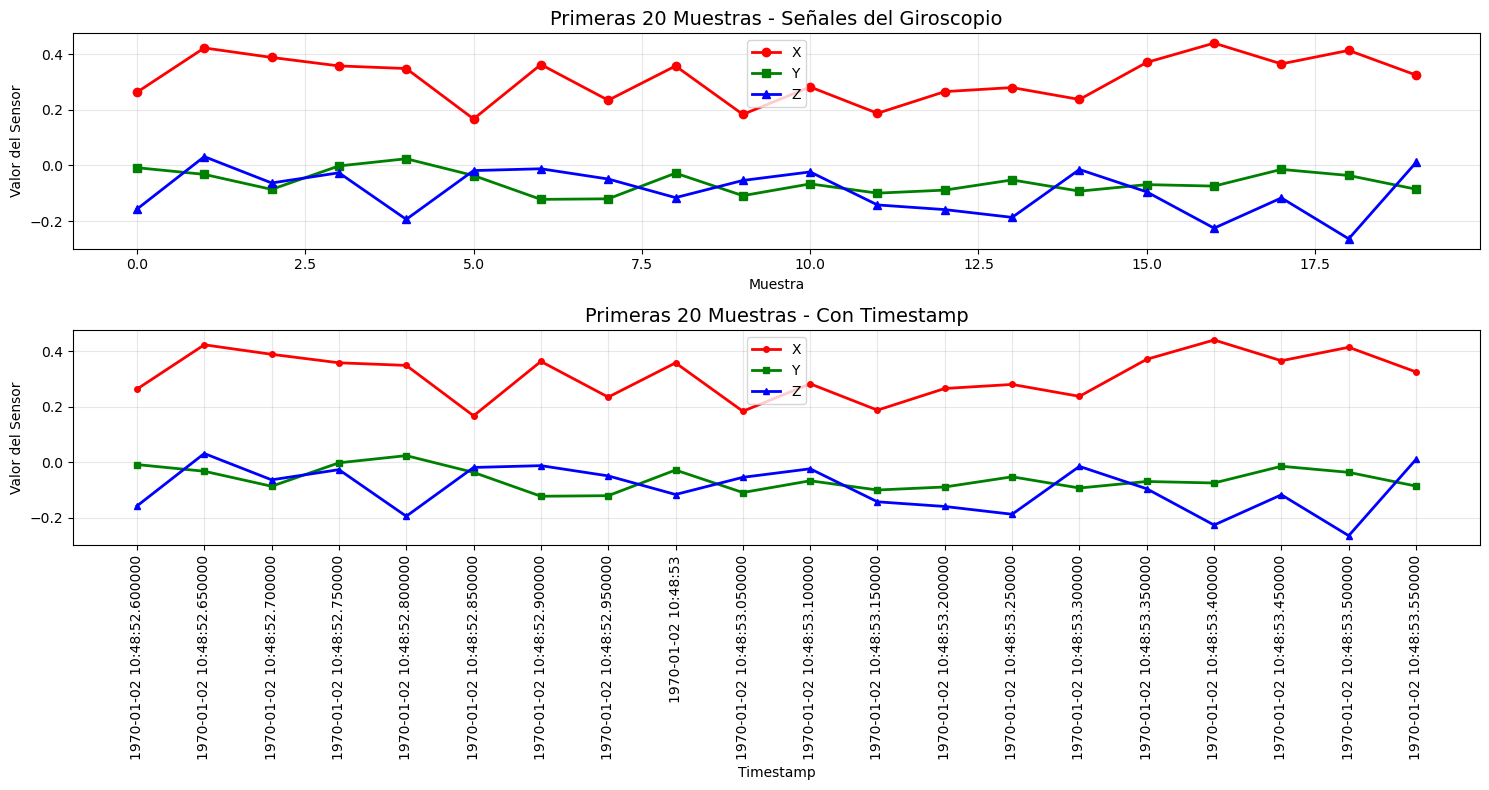

In [9]:
# Visualización de las primeras 20 muestras
plt.figure(figsize=(15, 8))

df = df_gyro_group
# Convertir a pandas para facilitar la visualización
df_sample = df.head(20).to_pandas()
df_sample['Tiempo Hora'] = df_sample['Timestamp'].dt.strftime('%H:%M:%S.%2f')

plt.subplot(2, 1, 1)
plt.plot(range(20), df_sample['X'], 'r-o', label='X', linewidth=2, markersize=6)
plt.plot(range(20), df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=6)
plt.plot(range(20), df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=6)
plt.title('Primeras 20 Muestras - Señales del Giroscopio', fontsize=14)
plt.xlabel('Muestra')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualización con timestamp real
plt.subplot(2, 1, 2)
plt.plot(df_sample['Tiempo Hora'], df_sample['X'], 'r-o', label='X', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=4)
plt.title('Primeras 20 Muestras - Con Timestamp', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [7]:
features_accel = create_feature_windows(df_accel)
features_gyro = create_feature_windows(df_gyro)

In [8]:
activities_dict = {
    'Walk': ['walk', 'stairsup', 'stairsdown'],
    'Stand': ['stand'],
    'Sit': ['sit'],
    'Others': ['null', 'bike']
}

In [ ]:
df_all_sensor = pd.merge(
    features_accel,
    features_gyro,
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'],
    how="inner"
)

In [ ]:
for activity in activities_dict.keys():
    for old_activity in activities_dict[activity]:
        df_all_sensor.loc[df_all_sensor['Activity Label'] == old_activity, 'Activity Label'] = activity

In [ ]:
from tensorflow import keras
model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn_lstm_har_model_92.h5')
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\label_encoder_92%.joblib')

In [22]:
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\label_encoder_92%.joblib')

In [25]:
X, y, _ = prepare_features_for_cnn_lstm_direct(df_all_sensor)
y = label_encoder.transform(y)

Características detectadas: 136
Muestras totales: 63


In [27]:
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X, y, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Pérdida en test: 11.3670
Precisión en test: 0.0000

REPORTE DE CLASIFICACIÓN


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

In [4]:
for user in df_all_sensor['Subject-id'].unique():
    print(f"{user}: {df_all_sensor[df_all_sensor['Subject-id'] == user].shape}")

1600.0: (1277, 141)
1601.0: (1274, 141)
1602.0: (1276, 141)
1603.0: (1274, 141)
1604.0: (1274, 141)
1605.0: (1278, 141)
1606.0: (1275, 141)
1607.0: (1276, 141)
1608.0: (1274, 141)
1609.0: (1276, 141)
1610.0: (1273, 141)
1611.0: (1272, 141)
1612.0: (1274, 141)
1613.0: (1270, 141)
1614.0: (1277, 141)
1615.0: (1273, 141)
1616.0: (1203, 141)
1617.0: (1273, 141)
1618.0: (1203, 141)
1619.0: (1276, 141)
1620.0: (1274, 141)
1621.0: (1273, 141)
1622.0: (1276, 141)
1623.0: (1274, 141)
1624.0: (1276, 141)
1625.0: (1272, 141)
1626.0: (1272, 141)
1627.0: (1273, 141)
1628.0: (1272, 141)
1629.0: (1306, 141)
1630.0: (1274, 141)
1631.0: (1274, 141)
1632.0: (1273, 141)
1633.0: (1275, 141)
1634.0: (1272, 141)
1635.0: (1273, 141)
1636.0: (1273, 141)
1637.0: (175, 141)
1638.0: (279, 141)
1639.0: (305, 141)
1640.0: (324, 141)
1641.0: (1274, 141)
1642.0: (1131, 141)
1643.0: (1274, 141)
1644.0: (1275, 141)
1645.0: (1273, 141)
1646.0: (1272, 141)
1647.0: (1277, 141)
1648.0: (1273, 141)
1649.0: (1275, 141)
1650